In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
plt.style.use("ggplot")

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix

C:\Users\z003txve.AD001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\z003txve.AD001\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [4]:
index = list(range(316200))
dataframe = pd.DataFrame(index = index)
dataframe['country'] = ['US','US','US','US','China','China','China','UK','UK','Germany'] * 31620
dataframe['age'] = np.random.randint(0,100,316200)
dataframe['new_user'] = np.random.randint(0,2,316200)
dataframe['total_pages_visited'] = np.random.randint(0,30,316200)
dataframe['converted'] = [1,0,0,0,0,0,0,1,0,0] * 31620
dataframe

,country,age,new_user,total_pages_visited,converted
0,US,42,0,0,1
1,US,99,0,13,0
2,US,36,1,17,0
3,US,96,1,20,0
4,China,64,1,8,0
5,China,39,0,15,0
6,China,47,0,3,0
7,UK,19,1,4,1
8,UK,56,1,24,0
9,Germany,4,1,25,0


In [5]:
dataframe.describe(exclude=None)

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,49.367780,0.499298,14.522144,0.200000
std,28.836683,0.500000,8.648201,0.400001
min,0.000000,0.000000,0.000000,0.000000
25%,24.000000,0.000000,7.000000,0.000000
50%,49.000000,0.000000,15.000000,0.000000
75%,74.000000,1.000000,22.000000,0.000000
max,99.000000,1.000000,29.000000,1.000000


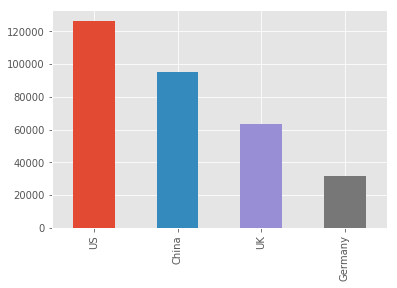

In [6]:
country_dist = dataframe.country.value_counts()
country_dist.plot(kind='bar')

In [7]:
convert_by_country_dist = dataframe.groupby('country')['converted'].mean()
convert_by_country_dist

country
China      0.00
Germany    0.00
UK         0.50
US         0.25
Name: converted, dtype: float64

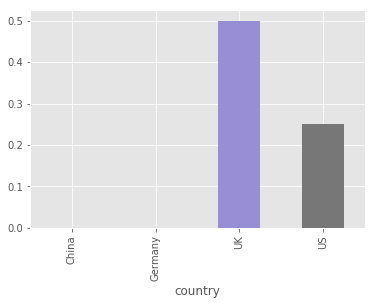

In [8]:
convert_by_country_dist.plot(kind="bar")

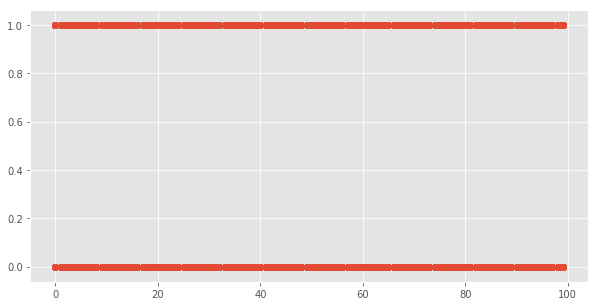

In [9]:
plt.figure(figsize=(10,5))
_ = plt.scatter(dataframe.age, dataframe.converted)

In [10]:
dataframe.head()

,country,age,new_user,total_pages_visited,converted
0,US,42,0,0,1
1,US,99,0,13,0
2,US,36,1,17,0
3,US,96,1,20,0
4,China,64,1,8,0


In [11]:
X = dataframe.loc[:,dataframe.columns.drop('converted')]
X = pd.get_dummies(X,columns = ['country'],prefix='',prefix_sep='')

In [12]:
X.head()

,age,new_user,total_pages_visited,China,Germany,UK,US
0,42,0,0,0,0,0,1
1,99,0,13,0,0,0,1
2,36,1,17,0,0,0,1
3,96,1,20,0,0,0,1
4,64,1,8,1,0,0,0


In [13]:
y = dataframe.converted
y.mean()

0.2

In [14]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,test_size = 0.333)

In [15]:
ytrain.mean(), ytest.mean()

(0.19989094616059364, 0.20021843392373806)

In [53]:
lrcv = LogisticRegressionCV(Cs = np.logspace(-3,3,7),scoring = 'roc_auc', max_iter = 1000, n_jobs = -1, verbose = 1)
lrcv.fit(Xtrain,ytrain)

[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   19.1s finished


LogisticRegressionCV(Cs=array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
           class_weight=None, cv=None, dual=False, fit_intercept=True,
           intercept_scaling=1.0, max_iter=1000, multi_class='ovr',
           n_jobs=-1, penalty='l2', random_state=None, refit=True,
           scoring='roc_auc', solver='lbfgs', tol=0.0001, verbose=1)

In [54]:
lrcv.C_

array([100.])

In [55]:
lrcv.scores_

{1: array([[0.81391544, 0.81391942, 0.81390602, 0.81391245, 0.81392008,
         0.81391944, 0.81392024],
        [0.81258409, 0.81261976, 0.8126193 , 0.81261941, 0.81262307,
         0.81262311, 0.81262307],
        [0.81248373, 0.81263783, 0.81265949, 0.81265232, 0.81265294,
         0.81265381, 0.81265263]])}